# Carregar o Conjunto de Dados


In [73]:
import pandas as pd

# Carregar o conjunto de dados
df_balanced = pd.read_csv('balanced_hate_data.csv')


# Visualizar a Distribuição das Etiquetas (Classes)


/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be rem

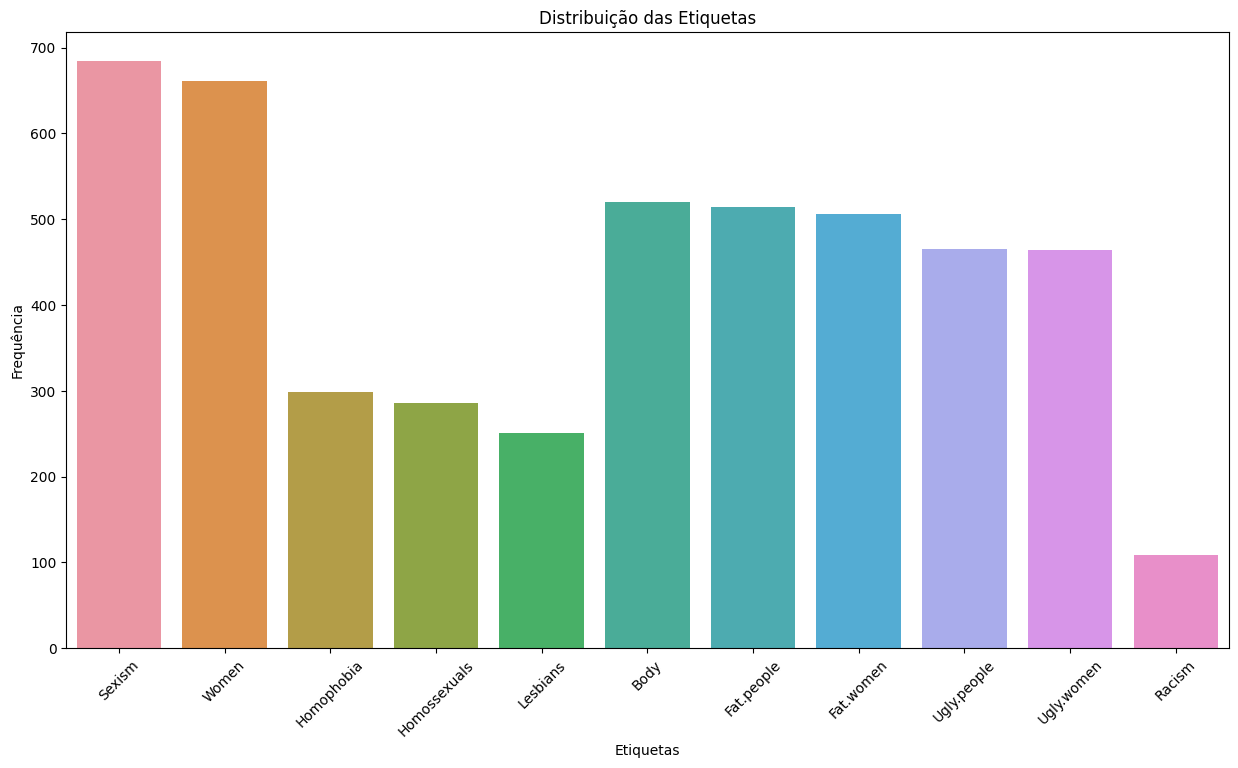

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colunas corretas para as etiquetas
correct_labels_columns = ['Sexism', 'Women', 'Homophobia', 'Homossexuals', 'Lesbians', 'Body', 'Fat.people', 'Fat.women', 'Ugly.people', 'Ugly.women', 'Racism']

# Visualizar a distribuição das várias etiquetas
plt.figure(figsize=(15, 8))
sns.barplot(x=correct_labels_columns, y=df_balanced[correct_labels_columns].sum().values)
plt.title("Distribuição das Etiquetas")
plt.xlabel("Etiquetas")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()


# Visualizar a Distribuição do Comprimento dos Textos


/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marcelo/anaconda3/envs/transformers/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


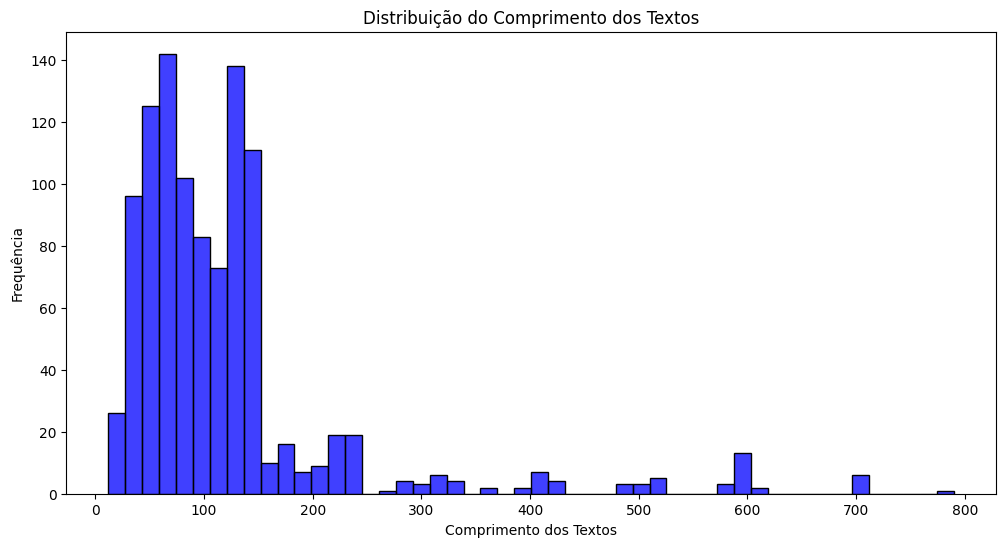

In [75]:
# Calcular o comprimento dos textos
df_balanced['text_length'] = df_balanced['text'].apply(len)

# Visualizar a distribuição do comprimento dos textos
plt.figure(figsize=(12, 6))
sns.histplot(df_balanced['text_length'], bins=50, kde=False, color='blue')
plt.title("Distribuição do Comprimento dos Textos")
plt.xlabel("Comprimento dos Textos")
plt.ylabel("Frequência")
plt.show()


# Treinamento 
### Pré-processamento e Divisão dos Dados

In [76]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#parametros 
batch_size = 8
# Tokenização e pad sequence
max_words = 500
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['text'])
sequences = tokenizer.texts_to_sequences(df_balanced['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Divisão dos dados
X = padded_sequences
y = df_balanced[correct_labels_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# equilibrando pesos

In [77]:
import numpy as np

# Calculando as frequências das classes
class_freq = np.sum(y_train, axis=0) / y_train.shape[0]

# Calculando os pesos como a inversa da frequência
class_weights = 1 / (class_freq + 1e-5)

# Criando um dicionário de pesos de classe
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    


# Primeira Topologia: Simples LSTM

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Modelo 1: Simples LSTM
model1 = Sequential([
    Embedding(1000, 32, input_length=max_sequence_length),
    LSTM(32),
    Dense(len(correct_labels_columns), activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

# Treinamento
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, class_weight=class_weight_dict)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 50, 32)            32000     
                                                                 
 lstm_25 (LSTM)              (None, 32)                8320      
                                                                 
 dense_31 (Dense)            (None, 11)                363       
                                                                 
Total params: 40683 (158.92 KB)
Trainable params: 40683 (158.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
84/84 [==============================] - 5s 35ms/step - loss: 1.7212 - accuracy: 0.4671 - val_loss: 0.6918 - val_accuracy: 0.6667
Epoch 2/20
84/84 [==============================] - 2s 28ms/step - loss: 1.6339 - accuracy: 0.5973 - val_loss: 0.6266 - val_accuracy: 0.26

# Segunda Topologia: LSTM + Dense Layer
### Nesta topologia, adicionaremos uma camada densa adicional entre a LSTM e a camada de saída.

In [79]:
# Modelo 2: LSTM + Dense
model2 = Sequential([
    Embedding(1000, 32, input_length=max_sequence_length),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(len(correct_labels_columns), activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

# Treinamento
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, class_weight=class_weight_dict)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 50, 32)            32000     
                                                                 
 lstm_26 (LSTM)              (None, 50, 32)            8320      
                                                                 
 lstm_27 (LSTM)              (None, 32)                8320      
                                                                 
 dense_32 (Dense)            (None, 32)                1056      
                                                                 
 dense_33 (Dense)            (None, 11)                363       
                                                                 
Total params: 50059 (195.54 KB)
Trainable params: 50059 (195.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
84/8

# Terceira Topologia: LSTM + Multiple Dense Layers
### Nesta topologia, adicionaremos múltiplas camadas densas para tornar o modelo mais complexo.



In [80]:
# Modelo 3: LSTM + Multiple Dense Layers
model3 = Sequential([
    Embedding(1000, 32, input_length=max_sequence_length),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(correct_labels_columns), activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

# Treinamento
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, class_weight=class_weight_dict)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 50, 32)            32000     
                                                                 
 lstm_28 (LSTM)              (None, 32)                8320      
                                                                 
 dense_34 (Dense)            (None, 64)                2112      
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dense_36 (Dense)            (None, 11)                363       
                                                                 
Total params: 44875 (175.29 KB)
Trainable params: 44875 (175.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
21/2

# analizando history

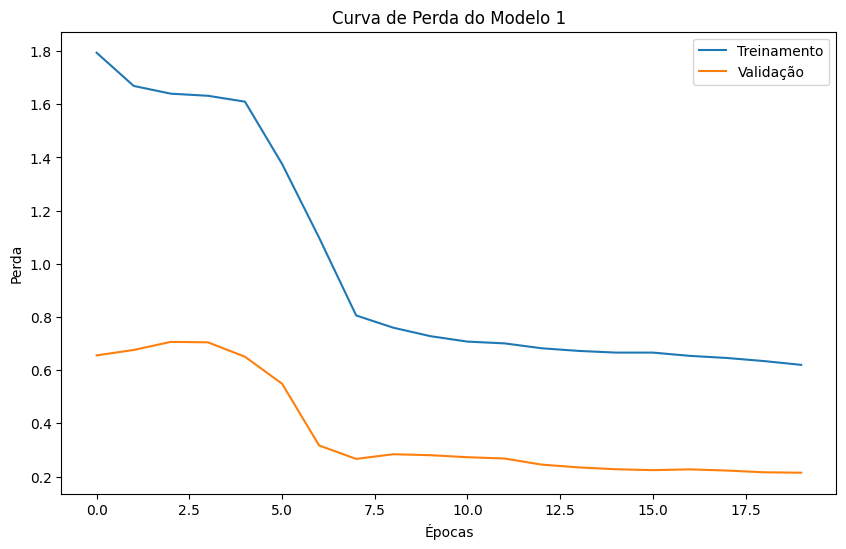

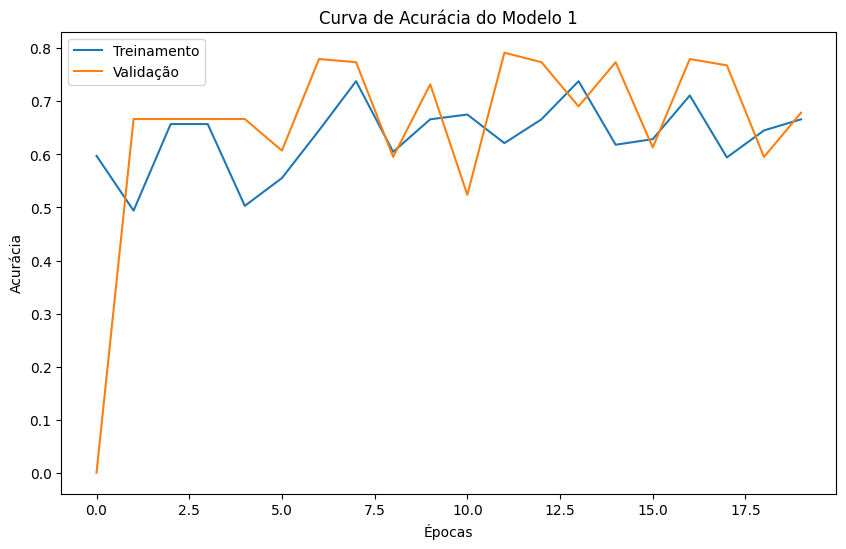

In [81]:
import matplotlib.pyplot as plt

pHistory = history3
# Plotando a curva de perda
plt.figure(figsize=(10, 6))
plt.plot(pHistory.history['loss'], label='Treinamento')
plt.plot(pHistory.history['val_loss'], label='Validação')
plt.title('Curva de Perda do Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Plotando a curva de acurácia
plt.figure(figsize=(10, 6))
plt.plot(pHistory.history['accuracy'], label='Treinamento')
plt.plot(pHistory.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia do Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


# teste com Texto :)

In [82]:
import pandas as pd

# Textos reais para teste
textos_reais = [
    "se a menina chama rayane quando faz 15 anos automaticamente fica grávida",
    "Antes o homossexualismo era proibido.Depois passou a ser tolerado.Hoje é normal.Eu vou embora antes que vire obrigatório",
    "pode ser feia,pode ser gorda... só não pode ser feia é gorda.",
    "Nada contra negros mas EU PREFIRO aquele branquelo palmito cor de leite pra bejar na boca rsrs",
    "nada contra negros mas minha filha não vai trazer bandido pra casa não"
]

# Inicializando uma lista vazia para armazenar os resultados finais
resultados_finais = []

# Loop para percorrer cada texto real
for texto in textos_reais:
    # Tokenização e padronização
    sequencias_reais = tokenizer.texts_to_sequences([texto])
    sequencias_padded = pad_sequences(sequencias_reais, maxlen=max_sequence_length, padding='post', truncating='post')

    # Previsões
    predicao1 = model1.predict(sequencias_padded)
    predicao2 = model2.predict(sequencias_padded)
    predicao3 = model3.predict(sequencias_padded)

    # Inicializando uma lista vazia para armazenar os resultados deste texto
    resultados = []

    # Preenchendo a lista com as previsões
    for i, col in enumerate(correct_labels_columns):
        novo_registro = {
            'Texto': texto,
            'Etiqueta': col,
            'Modelo 1 (%)': round(predicao1[0][i] * 100, 2),
            'Modelo 2 (%)': round(predicao2[0][i] * 100, 2),
            'Modelo 3 (%)': round(predicao3[0][i] * 100, 2)
        }
        resultados.append(novo_registro)

    # Adicionando os resultados deste texto à lista final
    resultados_finais.extend(resultados)

# Transformando a lista de dicionários em um DataFrame
df_resultados_finais = pd.DataFrame(resultados_finais)

# Visualizando o DataFrame
df_resultados_finais


1/1 [==============================] - 0s 29ms/step


,Texto,Etiqueta,Modelo 1 (%),Modelo 2 (%),Modelo 3 (%)
0,se a menina chama rayane quando faz 15 anos au...,Sexism,80.71,68.50,47.23
1,se a menina chama rayane quando faz 15 anos au...,Women,77.92,61.44,49.47
2,se a menina chama rayane quando faz 15 anos au...,Homophobia,20.24,0.92,45.14
3,se a menina chama rayane quando faz 15 anos au...,Homossexuals,20.02,0.87,41.04
4,se a menina chama rayane quando faz 15 anos au...,Lesbians,19.32,1.06,31.82
5,se a menina chama rayane quando faz 15 anos au...,Body,25.63,6.78,16.45
6,se a menina chama rayane quando faz 15 anos au...,Fat.people,15.37,9.40,20.65
7,se a menina chama rayane quando faz 15 anos au...,Fat.women,12.03,4.66,16.10
8,se a menina chama rayane quando faz 15 anos au...,Ugly.people,4.65,0.55,7.35
9,se a menina chama rayane quando faz 15 anos au...,Ugly.women,7.76,0.44,9.45


7/7 [==============================] - 0s 6ms/step


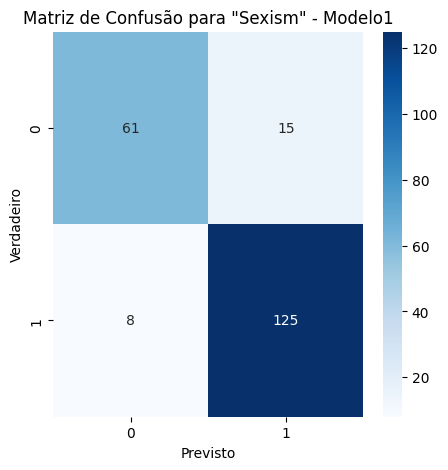

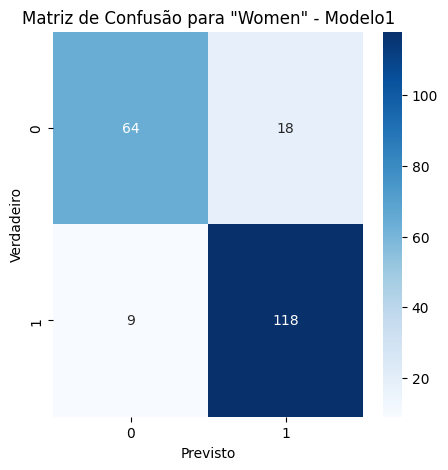

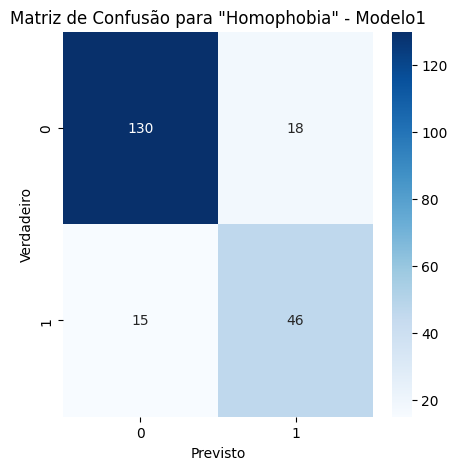

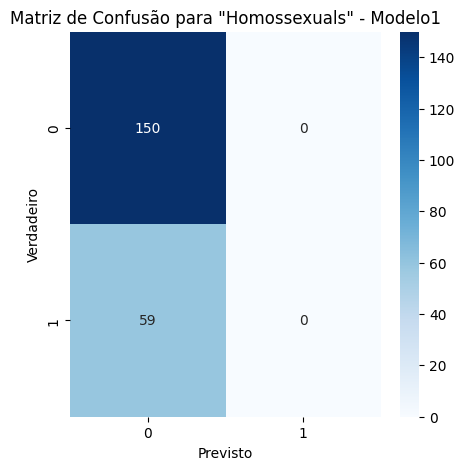

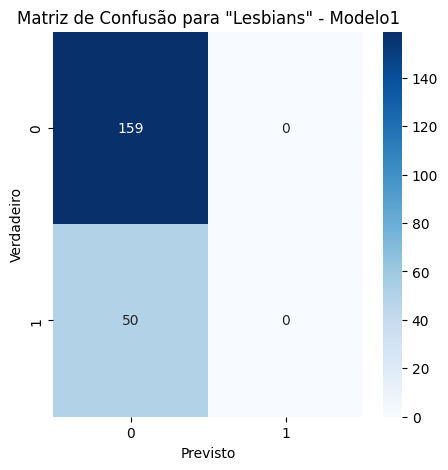

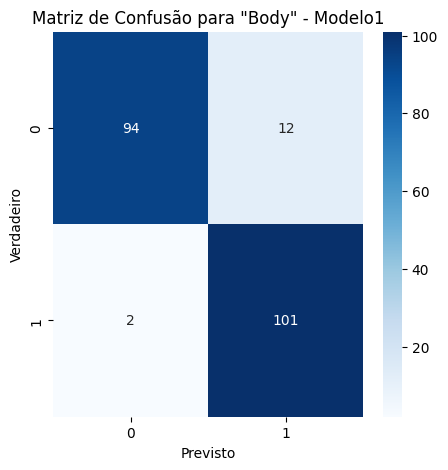

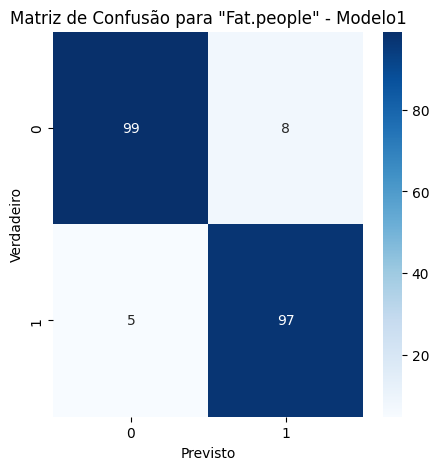

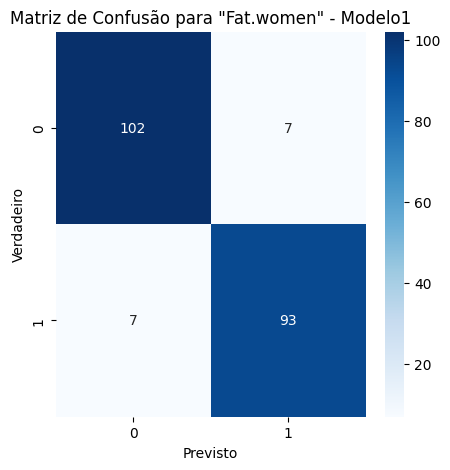

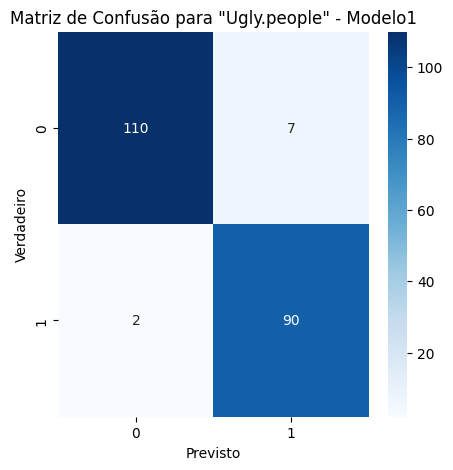

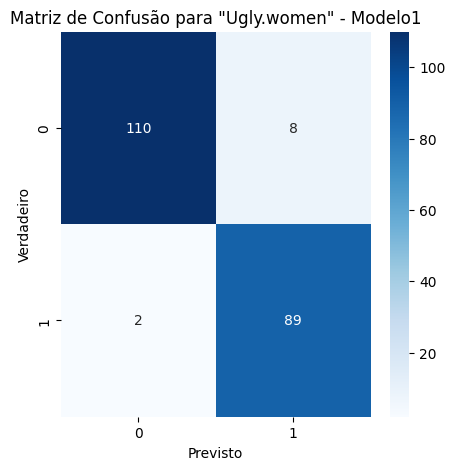

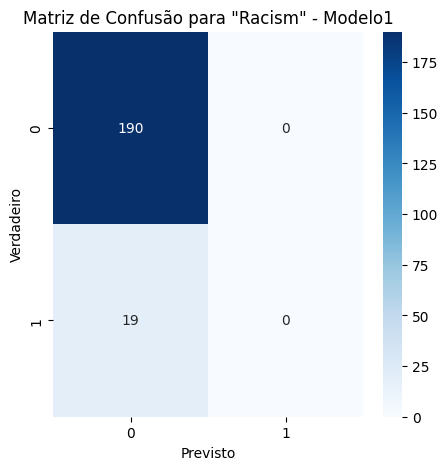

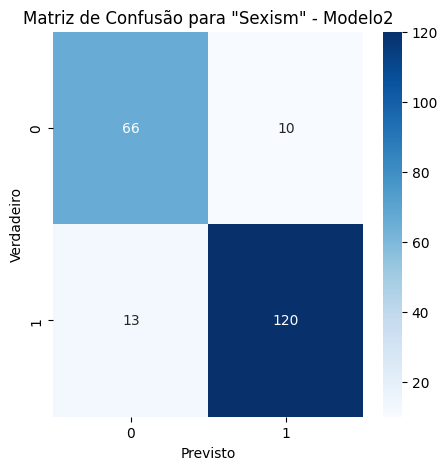

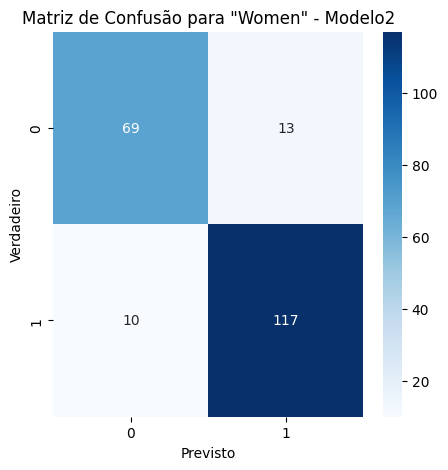

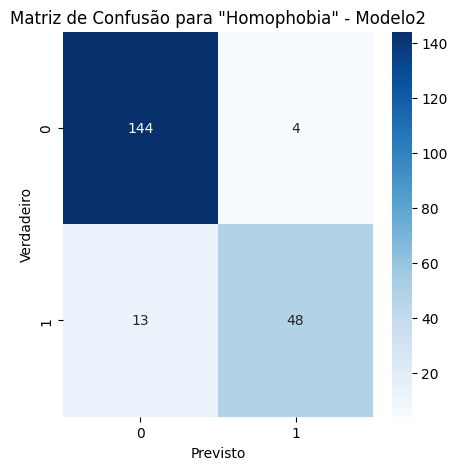

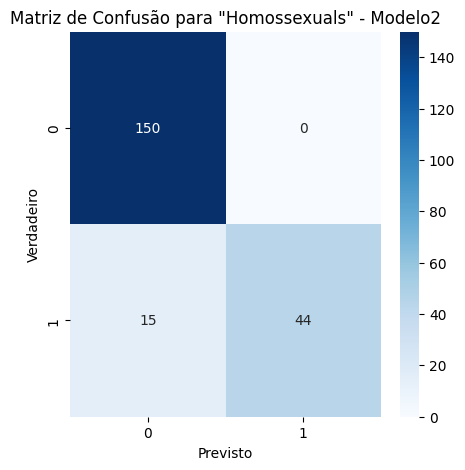

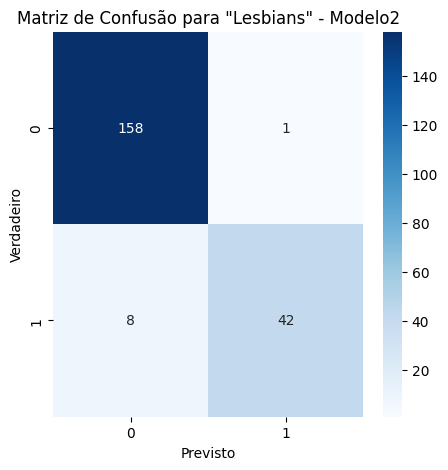

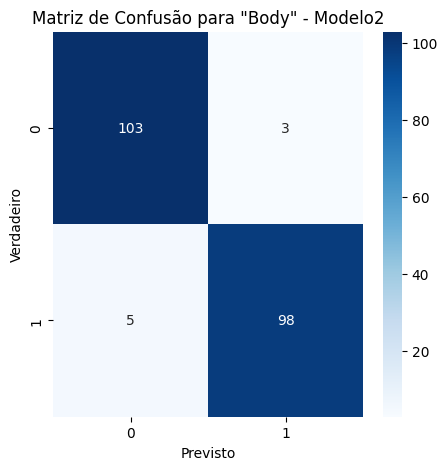

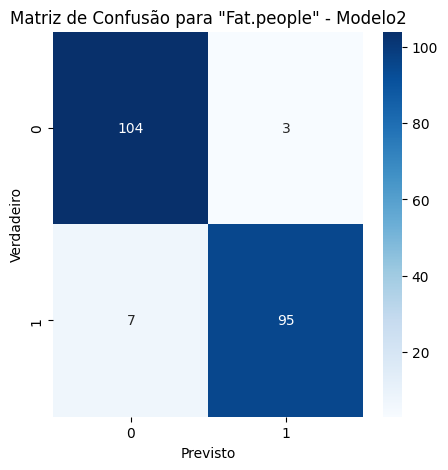

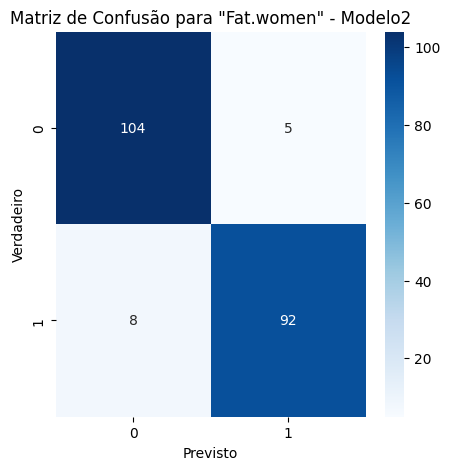

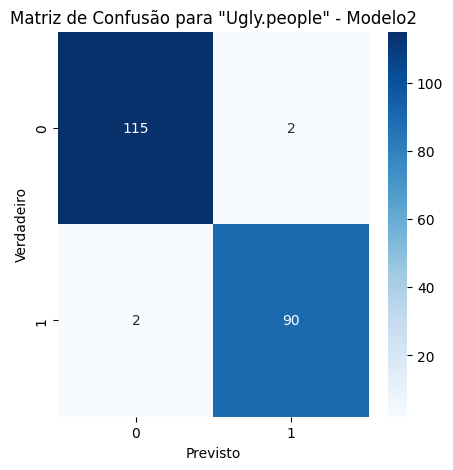

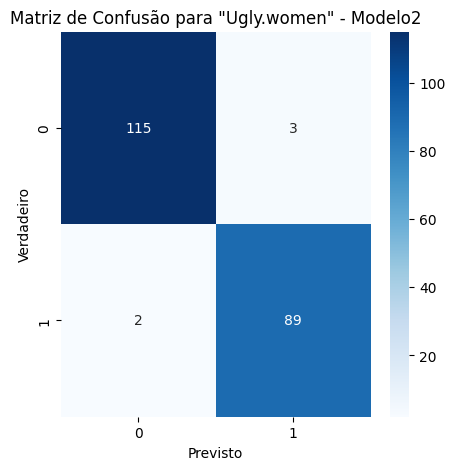

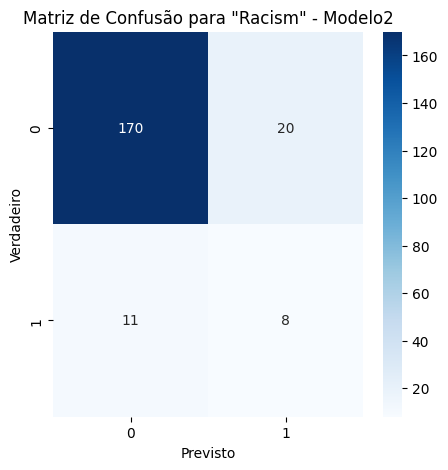

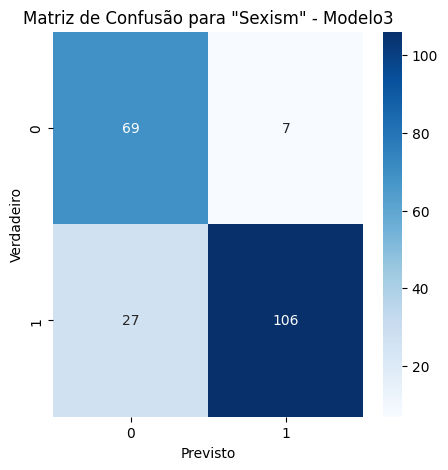

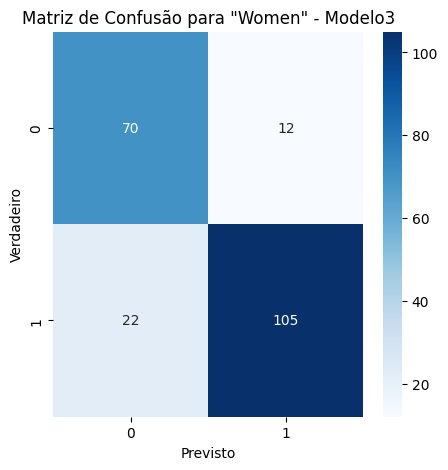

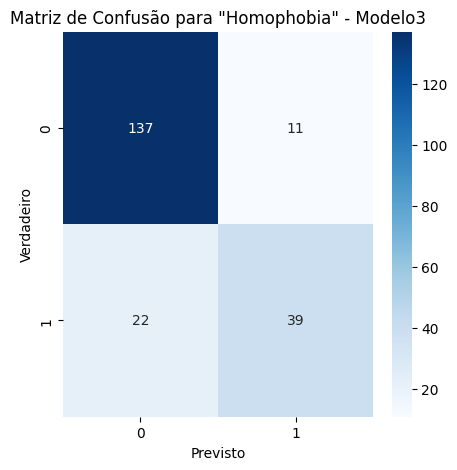

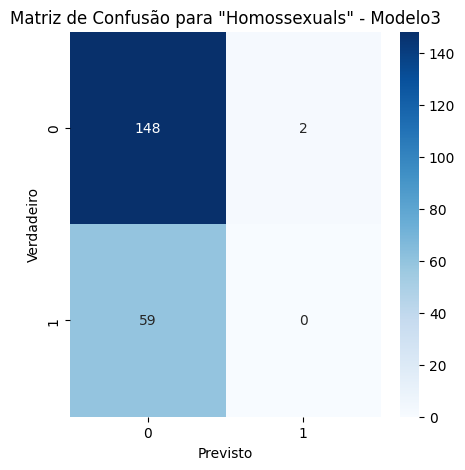

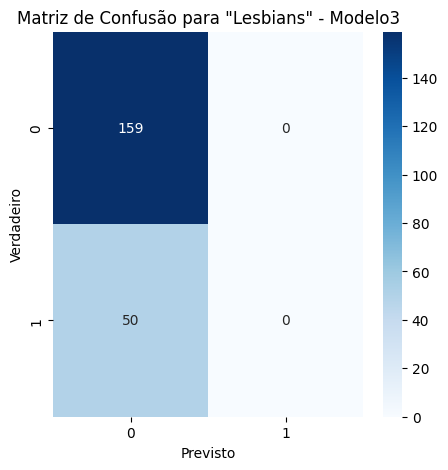

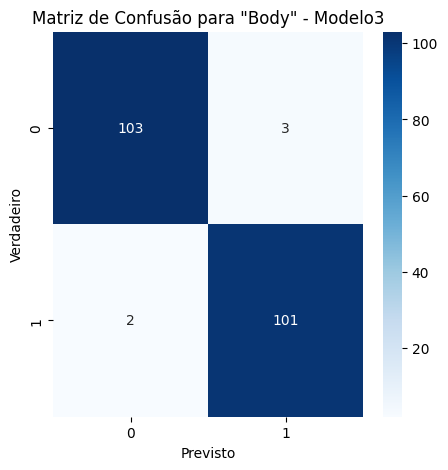

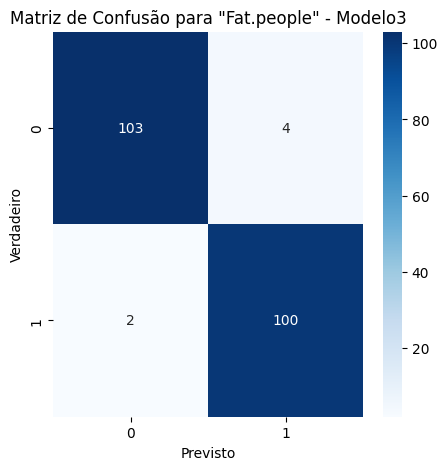

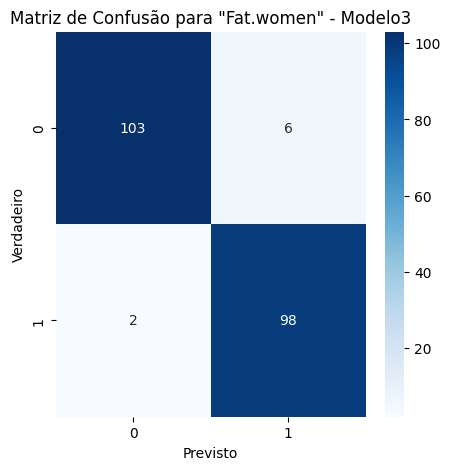

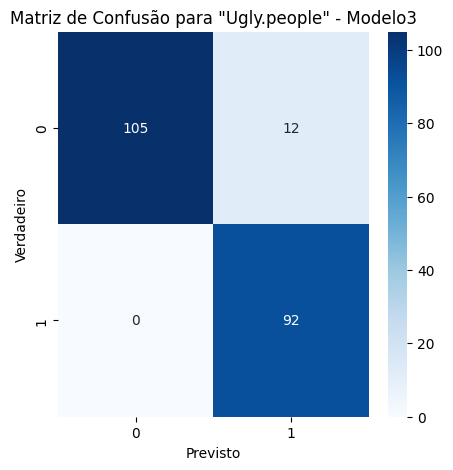

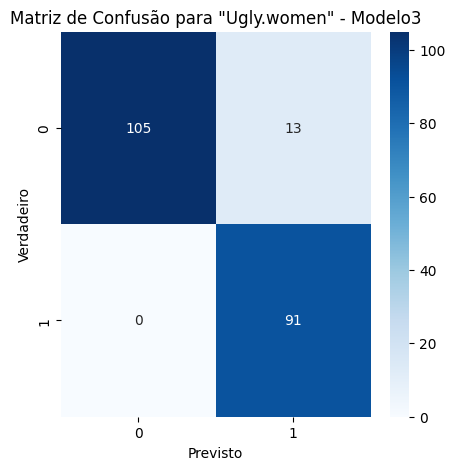

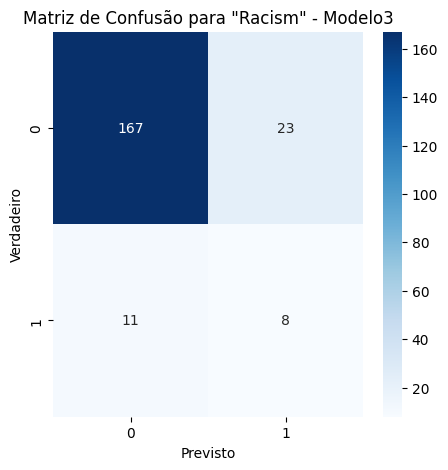

In [83]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(y_true, y_pred, label_names, model_name):
    cms = multilabel_confusion_matrix(y_true, y_pred)
    
    for i, (label, cm) in enumerate(zip(label_names, cms)):
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão para "{label}" - {model_name}')
        plt.xlabel('Previsto')
        plt.ylabel('Verdadeiro')
        plt.savefig(f'Confusion_Matrix_{model_name}_{label}.png')
        plt.show()

# Fazer previsões no conjunto de teste
y_pred1 = model1.predict(X_test) > 0.5
y_pred2 = model2.predict(X_test) > 0.5
y_pred3 = model3.predict(X_test) > 0.5

# Gerar as matrizes de confusão para todos os rótulos e modelos
plot_confusion_matrices(y_test, y_pred1, correct_labels_columns, 'Modelo1')
plot_confusion_matrices(y_test, y_pred2, correct_labels_columns, 'Modelo2')
plot_confusion_matrices(y_test, y_pred3, correct_labels_columns, 'Modelo3')
